In [1]:
import numpy as np
import pandas as pd
import obspy
import obspy.signal.filter
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import scipy
import glob
import sys
import matplotlib.pyplot as plt

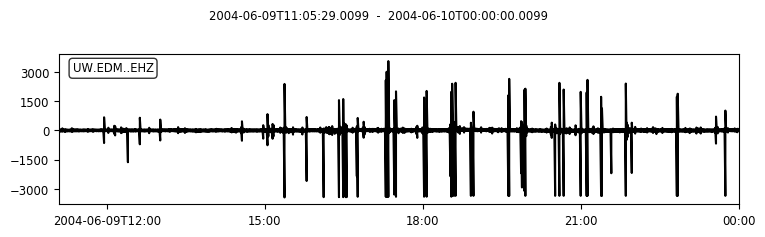

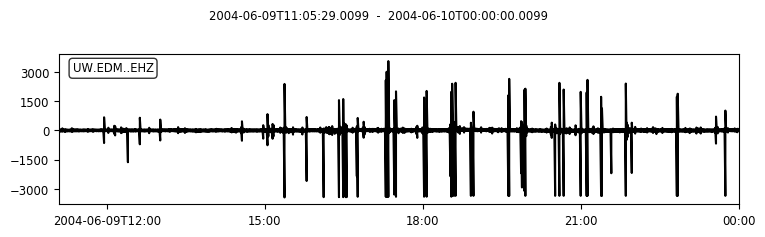

In [7]:
st = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/161/EDM.UW.2004.161')
st.detrend('demean')
st.merge()
st.plot()

In [317]:
st = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/023/EDM.UW.2004.023')
st.merge()
st[0].stats

         network: UW
         station: EDM
        location: 
         channel: EHZ
       starttime: 2004-01-23T00:00:00.000000Z
         endtime: 2004-01-24T00:00:00.000000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 8640001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 35, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 4096, 'filesize': 10936320})

In [21]:
glob.glob('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/*/SEP.UW.2004.*')

['/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/001/SEP.UW.2004.001',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/002/SEP.UW.2004.002',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/003/SEP.UW.2004.003',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/004/SEP.UW.2004.004',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/005/SEP.UW.2004.005',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/006/SEP.UW.2004.006',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/007/SEP.UW.2004.007',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/008/SEP.UW.2004.008',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/009/SEP.UW.2004.009',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/010/SEP.UW.2004.010',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/011/SEP.UW.2004.011',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/012/SEP.UW.2004.012',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/013/SEP.UW.2004.013',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/014/SEP.UW.2004.014',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/015/SEP.UW.2004.015',
 '/1-fnp/pnwstore1/p-wd05/PNW2004/UW/200

In [25]:
def read_stream_sta(jday, sta):
    st = obspy.Stream()
    st_d = obspy.Stream()
    try:
        # this stream will be used for RSAM and DSAR calculations
        #st_read = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st_read = client.get_waveforms(network='UW', station='{}'.format(sta), channel='*', 
                                       year=2004, doy='{}'.format(jday))
        st += st_read
        st.detrend('demean')
        
    except:
        print('pass {}'.format(jday))
    return(st)

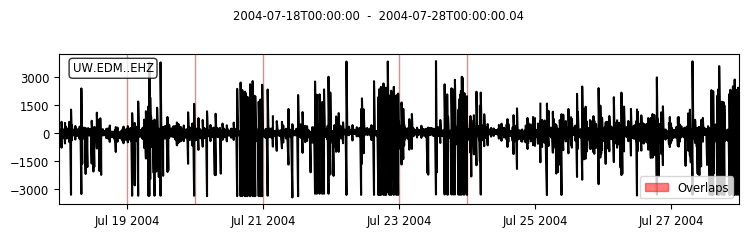

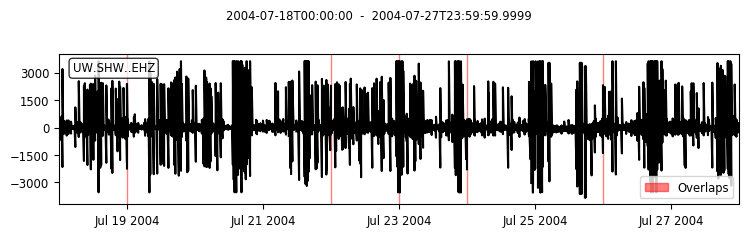

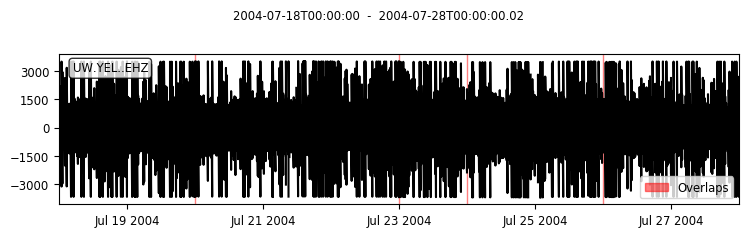

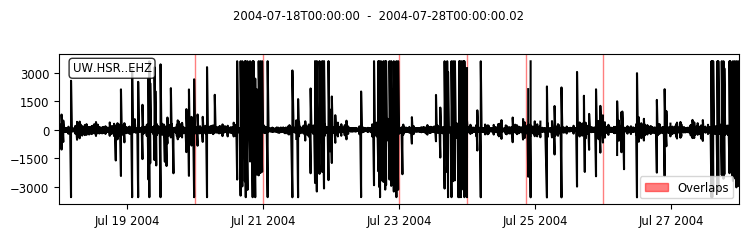

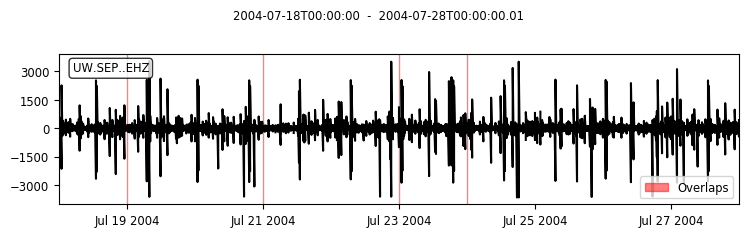

In [56]:
sta_list = ['EDM','SHW','YEL','HSR','SEP']
jdays = range(200,210)
for sta in sta_list:
    st = obspy.Stream()
    for jday in jdays:
        st_read = read_stream_sta(jday, sta)
        st += st_read
    st.plot()

In [2]:
def read_stream(jday):
    st = obspy.Stream()
    st_d = obspy.Stream()
    try:
        # this stream will be used for RSAM and DSAR calculations
        #st_read = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st_read = client.get_waveforms(network='UW', station='EDM', channel='*', year=2004, doy='{}'.format(jday))
        st += st_read
        st.detrend('demean')
        st.merge(method=0, fill_value=0, interpolation_samples=0)
        
        # this stream will be safed for the plot, therefor the stream is downsamplet but not processed
        st_dec = st_read.copy()
        st_dec = st_dec.decimate(15)  # downsampling for plot only
        #st_dec.detrend('demean')
        st_d += st_dec
        #st_d.merge()
        
    except:
        print('pass {}'.format(jday))
    return(st, st_d)

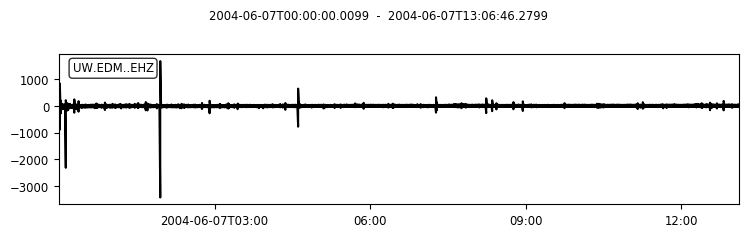

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-06-07T00:00:00.009900Z - 2004-06-07T13:06:46.279900Z | 100.0 Hz, 4720628 samples

In [35]:
jdays = ['159']#, '160', '161']
st = obspy.Stream()
st_d = obspy.Stream()
for jday in jdays:
    st_read, st_dec = read_stream(jday)
    st += st_read
    st_d += st_dec
st.plot()
st

In [18]:
datas = []
freqs_names = ['rsam','mf','hf', 'dsar']
daysec = 24*3600
freqs = [[2, 5], [4.5, 8], [8,16]]

tr = st[0]
data = tr.data
print(data)
samp_rate = tr.meta['sampling_rate']
ti = tr.meta['starttime']
# round start time to nearest 10 min increment
tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day))
ti = tiday+int(np.round((ti-tiday)/600))*600
N = int(600*samp_rate)    # 10 minute windows in seconds
Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
print(Nm)
# seconds per day (86400) * sampling rate (100) -> datapoints per day

for freq, frequ_name in zip(freqs, freqs_names[:3]):
    filtered_data = obspy.signal.filter.bandpass(data, freq[0], freq[1], samp_rate)
    filtered_data = abs(filtered_data[:Nm])
    datas.append(filtered_data.reshape(-1,N).mean(axis=-1)*1.e9)

[-13.9432603 -34.9432603 -18.9432603 ...,   7.0567397   9.0567397
   9.0567397]
4680000


In [59]:
inv = obspy.read_inventory()
inv
#st.remove_sensitivity(inv)

Inventory created at 2014-03-03T11:07:06.198000Z
	Created by: fdsn-stationxml-converter/1.0.0
		    http://www.iris.edu/fdsnstationconverter
	Sending institution: Erdbebendienst Bayern
	Contains:
		Networks (2):
			BW, GR
		Stations (5):
			BW.RJOB (Jochberg, Bavaria, BW-Net) (3x)
			GR.FUR (Fuerstenfeldbruck, Bavaria, GR-Net)
			GR.WET (Wettzell, Bavaria, GR-Net)
		Channels (30):
			BW.RJOB..EHZ (3x), BW.RJOB..EHN (3x), BW.RJOB..EHE (3x), 
			GR.FUR..BHZ, GR.FUR..BHN, GR.FUR..BHE, GR.FUR..HHZ, GR.FUR..HHN, 
			GR.FUR..HHE, GR.FUR..LHZ, GR.FUR..LHN, GR.FUR..LHE, GR.FUR..VHZ, 
			GR.FUR..VHN, GR.FUR..VHE, GR.WET..BHZ, GR.WET..BHN, GR.WET..BHE, 
			GR.WET..HHZ, GR.WET..HHN, GR.WET..HHE, GR.WET..LHZ, GR.WET..LHN, 
			GR.WET..LHE

In [57]:
st

35 Trace(s) in Stream:

UW.SEP..EHZ | 2004-07-18T00:00:00.000000Z - 2004-07-19T00:00:00.020000Z | 100.0 Hz, 8640003 samples
...
(33 other traces)
...
UW.SEP..EHZ | 2004-07-27T00:00:00.000000Z - 2004-07-28T00:00:00.010000Z | 100.0 Hz, 8640002 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [61]:
sum(np.isnan(obspy.signal.filter.bandpass(st[1], 5, 8, 100)))

0

In [91]:
obspy.signal.filter.bandpass(st[1], 5, 8, st[0].stats['sampling_rate'])

array([ -7.99934050e-04,  -5.40048986e-03,  -1.72848895e-02, ...,
        -1.13477793e+00,  -2.01944180e+00,  -2.27647051e+00])

In [723]:
np.argwhere(np.isnan(obspy.signal.filter.bandpass(st[1], 5, 8, 100)))

array([[  29100],
       [  29101],
       [  29102],
       ..., 
       [4647098],
       [4647099],
       [4647100]])

In [727]:
len(obspy.signal.filter.bandpass(st[0], 5, 8, 100))-len(obspy.signal.filter.bandpass(st[0], 5, 8, 100))

0

In [3]:
def RSAM(data, samp_rate, datas, freq, Nm, N):
    filtered_data = obspy.signal.filter.bandpass(data, freq[0], freq[1], samp_rate)
    filtered_data = abs(filtered_data[:Nm])
    datas.append(filtered_data.reshape(-1,N).mean(axis=-1)*1.e9)
    return(datas)

In [4]:
def DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute dsar
    data = scipy.integrate.cumtrapz(data, dx=1./100, initial=0) # vel to disp
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('hf')
    hfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    hfd = abs(hfd[:Nm])
    hfd = hfd.reshape(-1,N).mean(axis=-1)
    dsar = mfd/hfd
    datas.append(dsar)
    return(datas)

In [5]:
def write_csv(datas, ti, freqs_names, jday):
    # write out temporary file
    datas = np.array(datas)
    time = [(ti+j*600).datetime for j in range(datas.shape[1])]
    df = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
    print(df)
    #df.to_csv('tmp/_tmp_fl_{}.csv'.format(jday), index=True, index_label='time')
    return()

In [6]:
def freq_bands(jday):   
    ''' 
    calculate and store power in 10 min long time windows for different frequency bands
    sensor measured ground velocity
    freqs: list contains min and max frequency in Hz
    dsar: float represents displacement (integration of)'''
    
    datas = []
    freqs_names = ['rsam','mf','hf', 'dsar']
    daysec = 24*3600
    freqs = [[2, 5], [4.5, 8], [8,16]]
    
    st, st_dec = read_stream(jday)

    if len(st)>0: # if stream not empty
        data = st[0].data
        samp_rate = st[0].meta['sampling_rate']
        ti = st[0].meta['starttime']
        # round start time to nearest 10 min increment
        tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day))
        ti = tiday+int(np.round((ti-tiday)/600))*600
        N = int(600*samp_rate)    # 10 minute windows in seconds
        Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
        # seconds per day (86400) * sampling rate (100) -> datapoints per day
        
        for freq, frequ_name in zip(freqs, freqs_names[:3]):
            datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands
        
        datas = DSAR(data, datas, samp_rate, freqs_names, freqs, Nm, N)
        
        write_csv(datas, ti, freqs_names, jday)
        
    return(st_dec)

In [7]:
# calculate frequencie bands
jdays = ['{:03d}'.format(jday) for jday in range(159,160)]
print(jdays)
st_long = obspy.Stream()
for i, jday in enumerate(jdays,1):
    st_dec = freq_bands(jday)
    
    sys.stdout.write('\r{} of {}\n'.format(i, len(jdays)))
    sys.stdout.flush()

['159']


TypeError: 'float' object cannot be interpreted as an integer

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143'

                             rsam            mf            hf      dsar
2004-01-08 00:00:00  6.122359e+09  5.175112e+09  5.339768e+09  1.820500
2004-01-08 00:10:00  6.325006e+09  5.636431e+09  5.636093e+09  1.915062
2004-01-08 00:20:00  6.747630e+09  6.121340e+09  5.750592e+09  2.062560
2004-01-08 00:30:00  6.945373e+09  5.915188e+09  5.822938e+09  1.959309
2004-01-08 00:40:00  1.447430e+10  1.214534e+10  1.032914e+10  2.217152
...                           ...           ...           ...       ...
2004-01-08 23:10:00  3.925489e+09  3.860010e+09  4.608047e+09  1.686034
2004-01-08 23:20:00  3.588972e+09  3.367521e+09  4.363470e+09  1.560074
2004-01-08 23:30:00  3.424576e+09  3.213215e+09  4.312845e+09  1.545591
2004-01-08 23:40:00  3.738034e+09  3.453549e+09  4.455967e+09  1.592911
2004-01-08 23:50:00  3.680735e+09  3.245403e+09  4.389386e+09  1.535606

[144 rows x 4 columns]
8 of 366
                             rsam            mf            hf      dsar
2004-01-09 00:00:00  3.665136e+

                             rsam            mf            hf      dsar
2004-01-18 00:00:00  5.657633e+09  4.895088e+09  3.837985e+09  2.017890
2004-01-18 00:10:00  6.023433e+09  4.602660e+09  3.689612e+09  2.641026
2004-01-18 00:20:00  5.042961e+09  3.811892e+09  3.286415e+09  2.456945
2004-01-18 00:30:00  2.956694e+10  2.976371e+10  3.560377e+10  1.493686
2004-01-18 00:40:00  5.168983e+09  4.115915e+09  3.095991e+09  2.701525
...                           ...           ...           ...       ...
2004-01-18 23:00:00  3.600224e+09  2.779274e+09  2.850464e+09  1.956279
2004-01-18 23:10:00  3.284030e+09  2.440400e+09  2.535544e+09  1.883747
2004-01-18 23:20:00  4.878538e+09  3.226862e+09  2.719179e+09  2.381777
2004-01-18 23:30:00  8.159633e+09  6.577866e+09  7.864120e+09  1.677925
2004-01-18 23:40:00  3.079724e+09  2.065660e+09  2.513143e+09  1.676313

[143 rows x 4 columns]
18 of 366
                             rsam            mf            hf      dsar
2004-01-19 00:00:00  3.110021e

                             rsam            mf            hf      dsar
2004-01-28 00:00:00  3.054936e+09  1.982730e+09  2.259606e+09  1.823815
2004-01-28 00:10:00  3.198199e+09  2.034754e+09  2.252390e+09  1.966145
2004-01-28 00:20:00  2.126069e+10  2.017098e+10  2.182383e+10  1.759362
2004-01-28 00:30:00  3.238827e+09  1.896852e+09  2.237605e+09  1.873254
2004-01-28 00:40:00  5.097134e+09  3.778447e+09  4.184853e+09  1.784200
...                           ...           ...           ...       ...
2004-01-28 23:00:00  7.884484e+09  5.614270e+09  4.757322e+09  2.291344
2004-01-28 23:10:00  7.569116e+09  5.832627e+09  4.883373e+09  2.315259
2004-01-28 23:20:00  8.872829e+09  6.137734e+09  4.940612e+09  2.431399
2004-01-28 23:30:00  7.622738e+09  5.875975e+09  4.635530e+09  2.459540
2004-01-28 23:40:00  8.275495e+09  5.325616e+09  4.196016e+09  2.525161

[143 rows x 4 columns]
28 of 366
                             rsam            mf            hf      dsar
2004-01-29 00:00:00  7.563802e

                             rsam            mf            hf      dsar
2004-02-07 00:00:00  2.766887e+09  2.068225e+09  2.750966e+09  1.814628
2004-02-07 00:10:00  2.944487e+09  2.140350e+09  2.754210e+09  1.598999
2004-02-07 00:20:00  2.687078e+09  2.124741e+09  2.728707e+09  1.586299
2004-02-07 00:30:00  2.948218e+09  2.425611e+09  2.785510e+09  1.749585
2004-02-07 00:40:00  2.673745e+09  2.064993e+09  2.595411e+09  1.639766
...                           ...           ...           ...       ...
2004-02-07 23:10:00  3.709148e+09  2.578902e+09  2.487228e+09  2.221340
2004-02-07 23:20:00  4.100873e+09  2.827480e+09  2.506088e+09  2.428828
2004-02-07 23:30:00  3.885391e+09  2.591334e+09  2.452127e+09  2.299752
2004-02-07 23:40:00  4.273011e+09  2.999426e+09  2.753181e+09  2.371759
2004-02-07 23:50:00  4.426832e+09  3.084363e+09  2.575631e+09  2.536816

[144 rows x 4 columns]
38 of 366
                             rsam            mf            hf      dsar
2004-02-08 00:00:00  3.809969e

                             rsam            mf            hf      dsar
2004-02-17 00:00:00  3.727506e+09  2.882001e+09  3.104410e+09  1.821986
2004-02-17 00:10:00  4.964799e+09  4.121562e+09  4.326322e+09  1.859357
2004-02-17 00:20:00  3.823619e+09  3.075318e+09  3.320025e+09  1.847674
2004-02-17 00:30:00  3.584540e+09  2.858238e+09  3.190072e+09  1.819570
2004-02-17 00:40:00  3.669783e+09  3.057613e+09  3.194152e+09  1.925265
...                           ...           ...           ...       ...
2004-02-17 23:10:00  4.045479e+09  2.777796e+09  3.368175e+09  1.762216
2004-02-17 23:20:00  4.171268e+09  2.881186e+09  3.349831e+09  1.815158
2004-02-17 23:30:00  1.846184e+10  1.476929e+10  1.722144e+10  1.587026
2004-02-17 23:40:00  4.302235e+09  2.793803e+09  3.388552e+09  1.806544
2004-02-17 23:50:00  4.887992e+09  3.640151e+09  4.276864e+09  1.763555

[144 rows x 4 columns]
48 of 366
                             rsam            mf            hf      dsar
2004-02-18 00:00:00  3.931952e

                             rsam            mf            hf      dsar
2004-02-27 00:00:00  6.017279e+09  6.401268e+09  5.352494e+09  1.820785
2004-02-27 00:10:00  4.618900e+09  4.660632e+09  4.192851e+09  2.080256
2004-02-27 00:20:00  4.484035e+09  4.667309e+09  4.210848e+09  2.079673
2004-02-27 00:30:00  5.448123e+09  5.991858e+09  5.438153e+09  1.992943
2004-02-27 00:40:00  1.418845e+10  1.518379e+10  1.642400e+10  1.631281
...                           ...           ...           ...       ...
2004-02-27 23:10:00  3.634419e+09  2.602568e+09  3.736863e+09  1.460547
2004-02-27 23:20:00  2.609420e+09  2.159337e+09  3.432354e+09  1.358392
2004-02-27 23:30:00  3.759764e+09  3.291358e+09  5.249173e+09  1.294272
2004-02-27 23:40:00  5.180751e+09  4.949715e+09  7.614008e+09  1.334891
2004-02-27 23:50:00  1.091732e+10  1.046979e+10  1.246063e+10  1.659650

[144 rows x 4 columns]
58 of 366
                             rsam            mf            hf      dsar
2004-02-28 00:00:00  3.419139e

                             rsam            mf            hf      dsar
2004-03-08 00:00:00  4.967883e+09  4.423381e+09  5.554907e+09  1.818785
2004-03-08 00:10:00  2.443550e+10  2.938350e+10  2.758554e+10  1.912423
2004-03-08 00:20:00  3.396429e+09  2.579504e+09  3.357966e+09  1.637576
2004-03-08 00:30:00  3.532325e+09  2.753816e+09  3.849564e+09  1.465681
2004-03-08 00:40:00  8.769731e+09  1.146522e+10  1.247997e+10  1.544669
...                           ...           ...           ...       ...
2004-03-08 23:10:00  3.623121e+09  3.003890e+09  4.819408e+09  1.364063
2004-03-08 23:20:00  3.678945e+09  2.864931e+09  4.711273e+09  1.323071
2004-03-08 23:30:00  7.177043e+09  6.617469e+09  1.082302e+10  1.168620
2004-03-08 23:40:00  4.877168e+09  4.495379e+09  6.855033e+09  1.283815
2004-03-08 23:50:00  5.110619e+09  4.452460e+09  7.159895e+09  1.202534

[144 rows x 4 columns]
68 of 366
                             rsam            mf            hf      dsar
2004-03-09 00:00:00  3.816464e

                             rsam            mf            hf      dsar
2004-03-18 00:00:00  3.182156e+09  2.567084e+09  3.558582e+09  1.819394
2004-03-18 00:10:00  3.326145e+09  2.619971e+09  3.770096e+09  1.511083
2004-03-18 00:20:00  3.320045e+09  2.641810e+09  3.598549e+09  1.583702
2004-03-18 00:30:00  2.146634e+10  2.327537e+10  3.467672e+10  1.178243
2004-03-18 00:40:00  5.032831e+09  4.850000e+09  6.500436e+09  1.440218
...                           ...           ...           ...       ...
2004-03-18 23:00:00  1.292500e+10  9.984388e+09  6.416930e+09  2.904125
2004-03-18 23:10:00  1.034845e+10  7.663998e+09  4.678885e+09  3.177373
2004-03-18 23:20:00  8.624188e+09  5.780975e+09  3.646242e+09  3.258250
2004-03-18 23:30:00  7.780168e+09  5.392385e+09  3.563785e+09  3.041340
2004-03-18 23:40:00  6.999641e+09  5.025398e+09  3.523033e+09  2.906317

[143 rows x 4 columns]
78 of 366
                             rsam            mf            hf      dsar
2004-03-19 00:00:00  9.552494e

                             rsam            mf            hf      dsar
2004-03-28 00:00:00  4.513843e+09  2.434349e+09  2.639984e+09  1.823261
2004-03-28 00:10:00  6.689497e+09  4.149826e+09  5.263389e+09  1.523103
2004-03-28 00:20:00  3.728486e+09  2.009507e+09  2.560310e+09  1.710538
2004-03-28 00:30:00  3.552112e+09  2.191008e+09  2.799654e+09  1.674427
2004-03-28 00:40:00  3.901609e+09  2.378159e+09  3.029296e+09  1.649183
...                           ...           ...           ...       ...
2004-03-28 23:00:00  2.489496e+10  2.428462e+10  3.249888e+10  1.400727
2004-03-28 23:10:00  4.444287e+09  3.289903e+09  3.477323e+09  1.936985
2004-03-28 23:20:00  5.111539e+09  3.811034e+09  4.006784e+09  1.974545
2004-03-28 23:30:00  1.012916e+10  8.585386e+09  1.112387e+10  1.474359
2004-03-28 23:40:00  8.042982e+09  6.525011e+09  7.603334e+09  1.678608

[143 rows x 4 columns]
88 of 366
                             rsam            mf            hf      dsar
2004-03-29 00:00:00  4.399409e

                             rsam            mf            hf      dsar
2004-04-07 00:00:00  5.178430e+09  4.090813e+09  4.125499e+09  1.821131
2004-04-07 00:10:00  3.735616e+09  2.670651e+09  2.494463e+09  2.340968
2004-04-07 00:20:00  3.944292e+09  2.739431e+09  2.533288e+09  2.344894
2004-04-07 00:30:00  4.756604e+09  3.968596e+09  3.143140e+09  2.535350
2004-04-07 00:40:00  3.674707e+09  2.802778e+09  2.694953e+09  2.219458
...                           ...           ...           ...       ...
2004-04-07 23:10:00  4.980867e+09  3.858665e+09  3.203717e+09  2.381238
2004-04-07 23:20:00  4.390170e+09  2.951825e+09  2.679822e+09  2.318776
2004-04-07 23:30:00  5.562814e+09  4.114226e+09  3.256614e+09  2.537473
2004-04-07 23:40:00  4.266907e+09  2.639425e+09  2.591365e+09  2.125009
2004-04-07 23:50:00  5.254995e+09  3.436033e+09  3.606748e+09  1.959978

[144 rows x 4 columns]
98 of 366
                             rsam            mf            hf      dsar
2004-04-08 00:00:00  6.076441e

                             rsam            mf            hf      dsar
2004-04-17 00:00:00  6.529904e+09  5.739002e+09  6.844082e+09  1.819826
2004-04-17 00:10:00  6.370085e+09  5.370944e+09  7.216629e+09  1.433480
2004-04-17 00:20:00  2.230774e+10  2.270492e+10  1.775811e+10  2.414303
2004-04-17 00:30:00  3.771275e+09  2.625143e+09  2.857223e+09  1.938455
2004-04-17 00:40:00  3.840170e+09  2.478226e+09  2.800113e+09  1.919846
...                           ...           ...           ...       ...
2004-04-17 23:10:00  3.633666e+09  2.258396e+09  2.580453e+09  1.889408
2004-04-17 23:20:00  4.460389e+09  2.894004e+09  2.627972e+09  2.303540
2004-04-17 23:30:00  4.033024e+09  2.472331e+09  2.549039e+09  2.077242
2004-04-17 23:40:00  4.516962e+09  3.694173e+09  4.010573e+09  1.830429
2004-04-17 23:50:00  4.740948e+09  3.773704e+09  5.177755e+09  1.462131

[144 rows x 4 columns]
108 of 366
                             rsam            mf            hf      dsar
2004-04-18 00:00:00  4.208656

                             rsam            mf            hf      dsar
2004-04-27 00:00:00  5.541035e+09  5.108784e+09  5.763722e+09  1.819683
2004-04-27 00:10:00  8.266633e+09  7.280191e+09  8.380302e+09  1.678791
2004-04-27 00:20:00  6.144342e+09  5.681957e+09  6.428708e+09  1.746058
2004-04-27 00:30:00  4.141494e+09  3.780809e+09  4.758831e+09  1.591323
2004-04-27 00:40:00  4.150936e+09  3.256927e+09  3.543918e+09  1.950177
...                           ...           ...           ...       ...
2004-04-27 23:10:00  1.192143e+10  9.200131e+09  6.863420e+09  2.656589
2004-04-27 23:20:00  1.380140e+10  1.024845e+10  7.501491e+09  2.685986
2004-04-27 23:30:00  1.448154e+10  1.136751e+10  7.894044e+09  2.733408
2004-04-27 23:40:00  1.205146e+10  8.563177e+09  5.926264e+09  2.815745
2004-04-27 23:50:00  1.615809e+10  1.274087e+10  8.446197e+09  2.869534

[144 rows x 4 columns]
118 of 366
                             rsam            mf            hf      dsar
2004-04-28 00:00:00  1.299145

                             rsam            mf            hf      dsar
2004-05-07 00:00:00  4.116851e+09  3.888023e+09  4.410374e+09  1.818998
2004-05-07 00:10:00  7.059582e+09  6.578286e+09  7.743039e+09  1.662431
2004-05-07 00:20:00  3.986148e+09  3.549158e+09  4.108999e+09  1.718500
2004-05-07 00:30:00  5.676193e+09  4.698540e+09  4.423778e+09  2.120211
2004-05-07 00:40:00  4.058589e+09  3.550193e+09  3.793905e+09  1.868919
...                           ...           ...           ...       ...
2004-05-07 23:10:00  5.266648e+09  4.559581e+09  4.263296e+09  2.057138
2004-05-07 23:20:00  4.612937e+09  3.506924e+09  3.231586e+09  2.187442
2004-05-07 23:30:00  7.607488e+09  5.771167e+09  6.357828e+09  1.770355
2004-05-07 23:40:00  3.830299e+09  2.536736e+09  2.636827e+09  2.090655
2004-05-07 23:50:00  3.563392e+09  2.368082e+09  2.755822e+09  1.833262

[144 rows x 4 columns]
128 of 366
                             rsam            mf            hf      dsar
2004-05-08 00:00:00  2.702890

                             rsam            mf            hf      dsar
2004-05-17 00:00:00  3.106430e+09  2.585200e+09  3.241712e+09  1.820151
2004-05-17 00:10:00  3.156528e+09  2.814946e+09  3.240217e+09  1.805026
2004-05-17 00:20:00  3.643077e+09  3.467933e+09  3.651299e+09  1.937323
2004-05-17 00:30:00  3.178048e+09  2.926716e+09  3.197379e+09  1.909495
2004-05-17 00:40:00  3.589422e+09  3.319442e+09  3.567461e+09  1.922146
...                           ...           ...           ...       ...
2004-05-17 23:10:00  6.948832e+09  4.481123e+09  3.902453e+09  2.417809
2004-05-17 23:20:00  7.790389e+09  5.684431e+09  4.714960e+09  2.433267
2004-05-17 23:30:00  6.476069e+09  4.347091e+09  3.395105e+09  2.587223
2004-05-17 23:40:00  5.679249e+09  3.926491e+09  3.406016e+09  2.347697
2004-05-17 23:50:00  4.569297e+09  3.794505e+09  4.026530e+09  1.890931

[144 rows x 4 columns]
138 of 366
                             rsam            mf            hf      dsar
2004-05-18 00:00:00  6.746058

                             rsam            mf            hf      dsar
2004-05-27 00:00:00  1.118318e+10  1.093767e+10  9.817340e+09  1.839021
2004-05-27 00:10:00  1.090166e+10  1.182991e+10  9.090005e+09  2.327228
2004-05-27 00:20:00  7.665639e+09  7.653268e+09  6.848992e+09  2.057164
2004-05-27 00:30:00  8.073166e+09  8.030822e+09  6.999137e+09  2.124771
2004-05-27 00:40:00  1.868904e+10  2.043611e+10  1.505148e+10  2.389691
...                           ...           ...           ...       ...
2004-05-27 23:10:00  1.003037e+10  9.426022e+09  1.009418e+10  1.766065
2004-05-27 23:20:00  9.208892e+09  8.973814e+09  9.167692e+09  1.848613
2004-05-27 23:30:00  5.714573e+09  6.050097e+09  6.309925e+09  1.838627
2004-05-27 23:40:00  2.252892e+10  1.943648e+10  1.979412e+10  1.892655
2004-05-27 23:50:00  5.431069e+09  5.369459e+09  6.114849e+09  1.720250

[144 rows x 4 columns]
148 of 366
                             rsam            mf            hf      dsar
2004-05-28 00:00:00  2.629403

                             rsam            mf            hf      dsar
2004-06-06 00:00:00  1.162178e+10  1.101871e+10  1.191307e+10  1.813070
2004-06-06 00:10:00  8.865912e+09  1.071438e+10  1.151439e+10  1.678856
2004-06-06 00:20:00  1.079885e+10  1.353712e+10  1.354630e+10  1.763915
2004-06-06 00:30:00  1.864744e+10  2.437485e+10  2.545922e+10  1.686758
2004-06-06 00:40:00  1.413358e+10  1.765751e+10  1.797465e+10  1.753681
...                           ...           ...           ...       ...
2004-06-06 23:10:00  5.611584e+09  5.976790e+09  5.344501e+09  2.062675
2004-06-06 23:20:00  5.766426e+09  5.105403e+09  4.370724e+09  2.259660
2004-06-06 23:30:00  4.769837e+09  4.519188e+09  4.244800e+09  2.071686
2004-06-06 23:40:00  9.834100e+09  9.049557e+09  1.018138e+10  1.635793
2004-06-06 23:50:00  5.694839e+09  6.505461e+09  6.099418e+09  1.965811

[144 rows x 4 columns]
158 of 366
                             rsam            mf            hf      dsar
2004-06-07 00:00:00  1.499892

                             rsam            mf            hf      dsar
2004-06-17 00:00:00  2.850716e+08  2.820988e+08  3.916273e+08  1.820374
2004-06-17 00:10:00  2.814106e+08  2.679484e+08  3.802321e+08  1.370274
2004-06-17 00:20:00  2.723040e+08  2.610415e+08  3.576562e+08  1.412854
2004-06-17 00:30:00  2.905390e+08  2.719499e+08  3.695765e+08  1.411368
2004-06-17 00:40:00  2.909610e+08  2.673149e+08  3.718467e+08  1.381829
...                           ...           ...           ...       ...
2004-06-17 23:10:00  4.176566e+09  5.028347e+09  6.380583e+09  1.478788
2004-06-17 23:20:00  4.454629e+09  5.424881e+09  6.563790e+09  1.568748
2004-06-17 23:30:00  6.031095e+09  7.882874e+09  8.388771e+09  1.728244
2004-06-17 23:40:00  4.136293e+09  4.935906e+09  6.311301e+09  1.479732
2004-06-17 23:50:00  5.328236e+09  6.299757e+09  7.068026e+09  1.668173

[144 rows x 4 columns]
169 of 366
                             rsam            mf            hf      dsar
2004-06-18 00:00:00  8.645212

                             rsam            mf            hf      dsar
2004-06-27 00:00:00  1.776613e+10  1.376352e+10  1.584395e+10  1.819382
2004-06-27 00:10:00  1.357708e+10  1.183548e+10  9.776455e+09  2.215648
2004-06-27 00:20:00  5.028955e+09  5.137520e+09  5.304192e+09  1.863434
2004-06-27 00:30:00  7.101218e+09  8.910836e+09  9.704564e+09  1.667884
2004-06-27 00:40:00  5.512385e+09  5.602078e+09  5.555063e+09  1.931369
...                           ...           ...           ...       ...
2004-06-27 23:10:00  4.840762e+09  5.723077e+09  6.555977e+09  1.621644
2004-06-27 23:20:00  1.796570e+10  1.741135e+10  1.847184e+10  1.792511
2004-06-27 23:30:00  1.339826e+10  1.335626e+10  1.767155e+10  1.439560
2004-06-27 23:40:00  4.933796e+09  6.543256e+09  8.073740e+09  1.487236
2004-06-27 23:50:00  1.638092e+10  1.496779e+10  1.777157e+10  1.588547

[144 rows x 4 columns]
179 of 366
                             rsam            mf            hf      dsar
2004-06-28 00:00:00  7.679951

                             rsam            mf            hf      dsar
2004-07-07 00:00:00  4.497518e+09  5.283016e+09  7.161512e+09  1.813049
2004-07-07 00:10:00  5.821035e+09  7.400217e+09  8.315835e+09  1.649037
2004-07-07 00:20:00  4.771521e+09  6.177918e+09  7.714260e+09  1.487260
2004-07-07 00:30:00  5.238018e+09  6.059146e+09  7.374499e+09  1.562498
2004-07-07 00:40:00  3.758338e+10  5.164736e+10  3.573805e+10  2.413255
...                           ...           ...           ...       ...
2004-07-07 23:10:00  5.372453e+09  4.593825e+09  4.100842e+09  2.297542
2004-07-07 23:20:00  6.673245e+09  6.412875e+09  4.666134e+09  2.711938
2004-07-07 23:30:00  5.918054e+09  5.006507e+09  4.314063e+09  2.324096
2004-07-07 23:40:00  5.175531e+09  4.808505e+09  4.752202e+09  2.062193
2004-07-07 23:50:00  6.059835e+09  4.799537e+09  4.054927e+09  2.428224

[144 rows x 4 columns]
189 of 366
                             rsam            mf            hf      dsar
2004-07-08 00:00:00  5.461388

                             rsam            mf            hf      dsar
2004-07-17 00:00:00  1.166154e+10  1.743090e+10  1.627237e+10  1.821830
2004-07-17 00:10:00  5.562220e+09  7.631386e+09  9.882410e+09  1.418507
2004-07-17 00:20:00  6.863502e+09  9.321259e+09  1.083310e+10  1.581480
2004-07-17 00:30:00  7.059120e+09  9.950361e+09  1.151947e+10  1.570098
2004-07-17 00:40:00  5.618049e+09  8.265409e+09  1.055553e+10  1.417476
...                           ...           ...           ...       ...
2004-07-17 23:00:00  4.604198e+09  6.807819e+09  8.885271e+09  1.374319
2004-07-17 23:10:00  4.231905e+09  6.038226e+09  7.815942e+09  1.394793
2004-07-17 23:20:00  4.455174e+09  6.111034e+09  7.857385e+09  1.409946
2004-07-17 23:30:00  5.126523e+09  7.021252e+09  8.387351e+09  1.512228
2004-07-17 23:40:00  4.881138e+09  6.827522e+09  8.552861e+09  1.477160

[143 rows x 4 columns]
199 of 366
                             rsam            mf            hf      dsar
2004-07-18 00:00:00  8.658453

                             rsam            mf            hf      dsar
2004-07-27 00:00:00  1.260689e+10  1.761288e+10  1.556332e+10  1.820999
2004-07-27 00:10:00  6.865170e+09  8.447776e+09  9.971029e+09  1.555768
2004-07-27 00:20:00  9.409732e+09  1.189355e+10  1.168939e+10  1.818860
2004-07-27 00:30:00  8.458864e+09  1.115359e+10  1.154568e+10  1.721977
2004-07-27 00:40:00  6.226737e+09  8.213746e+09  9.228098e+09  1.633337
...                           ...           ...           ...       ...
2004-07-27 23:10:00  9.825641e+09  1.343515e+10  1.376967e+10  1.728434
2004-07-27 23:20:00  9.466815e+09  1.144984e+10  1.409052e+10  1.540832
2004-07-27 23:30:00  7.136703e+09  9.874792e+09  1.136377e+10  1.562916
2004-07-27 23:40:00  5.917756e+09  8.722648e+09  1.036863e+10  1.498130
2004-07-27 23:50:00  6.330118e+09  9.157826e+09  1.042234e+10  1.569955

[144 rows x 4 columns]
209 of 366
                             rsam            mf            hf      dsar
2004-07-28 00:00:00  6.011692

                             rsam            mf            hf      dsar
2004-08-06 00:00:00  3.934584e+09  3.697079e+09  5.088702e+09  1.819186
2004-08-06 00:10:00  3.652480e+09  3.223018e+09  3.215397e+09  2.058336
2004-08-06 00:20:00  3.780434e+09  3.316960e+09  3.201222e+09  2.088024
2004-08-06 00:30:00  3.750028e+09  3.648698e+09  3.826496e+09  1.881705
2004-08-06 00:40:00  3.997410e+09  4.225417e+09  4.455482e+09  1.861925
...                           ...           ...           ...       ...
2004-08-06 23:00:00  1.317853e+10  1.785298e+10  1.626499e+10  1.908876
2004-08-06 23:10:00  2.689080e+10  3.877941e+10  3.317991e+10  1.998806
2004-08-06 23:20:00  2.178170e+10  2.886459e+10  2.810828e+10  1.765808
2004-08-06 23:30:00  2.188056e+10  3.388444e+10  4.079439e+10  1.461098
2004-08-06 23:40:00  1.935539e+10  2.954703e+10  3.597133e+10  1.464898

[143 rows x 4 columns]
219 of 366
                             rsam            mf            hf      dsar
2004-08-07 00:00:00  2.136999

                             rsam            mf            hf      dsar
2004-08-16 00:00:00  1.027747e+10  1.430050e+10  1.519821e+10  1.802394
2004-08-16 00:10:00  9.950880e+09  1.434070e+10  1.508982e+10  1.670637
2004-08-16 00:20:00  1.513679e+10  1.529949e+10  1.513885e+10  1.823524
2004-08-16 00:30:00  1.198817e+10  1.771179e+10  1.791572e+10  1.714318
2004-08-16 00:40:00  9.056913e+09  1.262329e+10  1.382318e+10  1.599309
...                           ...           ...           ...       ...
2004-08-16 23:10:00  9.584107e+09  1.117319e+10  1.122492e+10  1.799582
2004-08-16 23:20:00  1.147510e+10  1.282006e+10  1.112209e+10  2.077929
2004-08-16 23:30:00  1.486022e+10  1.726027e+10  1.368909e+10  2.218155
2004-08-16 23:40:00  1.174809e+10  1.384478e+10  1.395628e+10  1.775480
2004-08-16 23:50:00  1.231165e+10  1.595086e+10  1.596347e+10  1.761417

[144 rows x 4 columns]
229 of 366
                             rsam            mf            hf      dsar
2004-08-17 00:00:00  9.645092

                             rsam            mf            hf      dsar
2004-08-26 00:00:00  2.408109e+11  2.547674e+11  1.390190e+11  2.183244
2004-08-26 00:10:00  2.235465e+11  1.797530e+11  8.175218e+10  3.729443
2004-08-26 00:20:00  1.304009e+11  1.213725e+11  5.829959e+10  3.538165
2004-08-26 00:30:00  1.053129e+11  9.265816e+10  4.428379e+10  3.564097
2004-08-26 00:40:00  8.163751e+10  8.514223e+10  4.784838e+10  2.986913
...                           ...           ...           ...       ...
2004-08-26 23:10:00  1.712797e+10  1.881754e+10  1.715771e+10  1.920179
2004-08-26 23:20:00  1.938823e+10  2.666827e+10  2.462156e+10  1.837435
2004-08-26 23:30:00  3.305093e+10  3.881310e+10  3.520163e+10  1.940383
2004-08-26 23:40:00  8.641851e+09  8.849026e+09  8.194502e+09  1.941273
2004-08-26 23:50:00  9.164310e+09  1.037019e+10  9.619773e+09  1.882306

[144 rows x 4 columns]
239 of 366
                             rsam            mf            hf      dsar
2004-08-27 00:00:00  1.005242

                             rsam            mf            hf      dsar
2004-09-05 00:00:00  9.278461e+09  9.275929e+09  8.023821e+09  1.828561
2004-09-05 00:10:00  8.382622e+09  7.832918e+09  6.533127e+09  2.180235
2004-09-05 00:20:00  7.341362e+09  6.909673e+09  5.825809e+09  2.170489
2004-09-05 00:30:00  7.598755e+09  7.385952e+09  6.655663e+09  2.005276
2004-09-05 00:40:00  6.975907e+09  6.344749e+09  5.938701e+09  1.986329
...                           ...           ...           ...       ...
2004-09-05 23:10:00  4.340408e+10  4.594791e+10  2.632588e+10  2.875098
2004-09-05 23:20:00  1.355699e+10  1.835626e+10  1.665703e+10  1.856990
2004-09-05 23:30:00  5.127023e+09  5.147266e+09  5.374204e+09  1.788654
2004-09-05 23:40:00  1.102387e+10  1.269908e+10  9.183211e+09  2.481956
2004-09-05 23:50:00  5.147494e+09  5.152514e+09  5.500439e+09  1.743908

[144 rows x 4 columns]
249 of 366
                             rsam            mf            hf      dsar
2004-09-06 00:00:00  5.654445

                             rsam            mf            hf      dsar
2004-09-15 00:00:00  1.025273e+10  1.052532e+10  9.358997e+09  1.881654
2004-09-15 00:10:00  1.013751e+10  9.054587e+09  7.619636e+09  2.265080
2004-09-15 00:20:00  1.076587e+10  1.173012e+10  9.135450e+09  2.348191
2004-09-15 00:30:00  9.312197e+09  7.640902e+09  6.406051e+09  2.296099
2004-09-15 00:40:00  1.745931e+10  1.453499e+10  7.873575e+09  3.485866
...                           ...           ...           ...       ...
2004-09-15 23:10:00  1.506089e+10  1.636991e+10  1.250709e+10  2.237157
2004-09-15 23:20:00  1.097779e+10  1.021527e+10  8.390901e+09  2.318399
2004-09-15 23:30:00  9.619778e+09  8.267138e+09  5.712841e+09  2.692094
2004-09-15 23:40:00  1.193142e+10  1.328410e+10  9.854819e+09  2.304457
2004-09-15 23:50:00  1.445661e+10  1.475686e+10  1.059332e+10  2.490838

[144 rows x 4 columns]
259 of 366
                             rsam            mf            hf      dsar
2004-09-16 00:00:00  1.415619

                             rsam            mf            hf      dsar
2004-09-25 00:00:00  8.943127e+10  1.074190e+11  7.514652e+10  1.965520
2004-09-25 00:10:00  8.045863e+10  9.156868e+10  6.746354e+10  2.371034
2004-09-25 00:20:00  4.970949e+10  5.604764e+10  4.562040e+10  2.136551
2004-09-25 00:30:00  2.743853e+10  2.964410e+10  2.481968e+10  2.141175
2004-09-25 00:40:00  2.539351e+10  2.802386e+10  2.286915e+10  2.139295
...                           ...           ...           ...       ...
2004-09-25 23:10:00  1.074647e+10  9.748557e+09  7.434394e+09  2.336758
2004-09-25 23:20:00  1.040588e+10  1.002613e+10  7.857083e+09  2.239568
2004-09-25 23:30:00  9.861975e+10  6.498769e+10  3.801231e+10  3.040170
2004-09-25 23:40:00  1.150798e+10  1.102658e+10  7.540478e+09  2.624588
2004-09-25 23:50:00  1.053572e+10  9.772784e+09  7.032988e+09  2.502602

[144 rows x 4 columns]
269 of 366
                             rsam            mf            hf      dsar
2004-09-26 00:00:00  1.321310

                             rsam            mf            hf      dsar
2004-10-05 00:00:00  1.497569e+12  9.043796e+11  5.152919e+11  2.921842
2004-10-05 00:10:00  1.526880e+12  8.969916e+11  5.009913e+11  3.241226
2004-10-05 00:20:00  1.516429e+12  8.970621e+11  5.059639e+11  3.210013
2004-10-05 00:30:00  1.513572e+12  9.231823e+11  5.190298e+11  3.181538
2004-10-05 00:40:00  1.499145e+12  9.081270e+11  5.137657e+11  3.208450
...                           ...           ...           ...       ...
2004-10-05 23:10:00  8.200305e+11  5.103604e+11  2.545151e+11  3.569297
2004-10-05 23:20:00  7.498914e+11  4.518301e+11  2.405393e+11  3.402857
2004-10-05 23:30:00  6.964803e+11  4.343025e+11  2.261326e+11  3.462575
2004-10-05 23:40:00  7.911821e+11  4.636519e+11  2.517783e+11  3.318312
2004-10-05 23:50:00  7.504230e+11  4.750002e+11  2.459491e+11  3.450765

[144 rows x 4 columns]
279 of 366
                             rsam            mf            hf      dsar
2004-10-06 00:00:00  7.238662

                             rsam            mf            hf      dsar
2004-10-15 00:00:00  5.122248e+11  2.863514e+11  1.756374e+11  2.118961
2004-10-15 00:10:00  5.049283e+11  2.721412e+11  1.509458e+11  3.392576
2004-10-15 00:20:00  4.613833e+11  2.707119e+11  5.610943e+11  0.918670
2004-10-15 00:30:00  5.443526e+11  2.721145e+11  1.324513e+11  3.685644
2004-10-15 00:40:00  4.560110e+11  2.451911e+11  2.662169e+11  1.996103
...                           ...           ...           ...       ...
2004-10-15 23:10:00  4.760859e+11  2.566259e+11  9.869967e+10  4.531178
2004-10-15 23:20:00  5.508454e+11  2.821983e+11  1.141533e+11  4.407603
2004-10-15 23:30:00  5.633482e+11  2.830287e+11  1.132991e+11  4.317432
2004-10-15 23:40:00  5.308271e+11  2.854420e+11  1.109168e+11  4.507539
2004-10-15 23:50:00  4.539261e+11  2.462310e+11  1.026112e+11  4.109671

[144 rows x 4 columns]
289 of 366
                             rsam            mf            hf      dsar
2004-10-16 00:00:00  5.061313

                             rsam            mf            hf      dsar
2004-10-25 00:00:00  9.695085e+11  3.813296e+11  1.411056e+11  3.940947
2004-10-25 00:10:00  1.014269e+12  4.208327e+11  1.602322e+11  4.662816
2004-10-25 00:20:00  9.603168e+11  3.972845e+11  1.458047e+11  4.773147
2004-10-25 00:30:00  1.052512e+12  4.066089e+11  1.490815e+11  4.796455
2004-10-25 00:40:00  9.428643e+11  3.779624e+11  1.327433e+11  4.979378
...                           ...           ...           ...       ...
2004-10-25 23:10:00  8.498335e+11  3.297794e+11  1.089088e+11  5.343821
2004-10-25 23:20:00  8.042644e+11  3.294226e+11  1.042997e+11  5.481731
2004-10-25 23:30:00  8.781771e+11  3.499596e+11  1.208161e+11  5.040224
2004-10-25 23:40:00  8.630843e+11  3.497745e+11  1.139014e+11  5.349449
2004-10-25 23:50:00  8.077490e+11  3.397478e+11  1.070919e+11  5.514750

[144 rows x 4 columns]
299 of 366
                             rsam            mf            hf      dsar
2004-10-26 00:00:00  7.401423

                             rsam            mf            hf      dsar
2004-11-04 00:00:00  8.715231e+11  4.239751e+11  1.534727e+11  3.215416
2004-11-04 00:10:00  8.303950e+11  4.288915e+11  1.379625e+11  5.296358
2004-11-04 00:20:00  8.213200e+11  4.009533e+11  1.376419e+11  4.993638
2004-11-04 00:30:00  7.851912e+11  3.981861e+11  1.318895e+11  5.094829
2004-11-04 00:40:00  8.375914e+11  4.156395e+11  1.439276e+11  4.935721
...                           ...           ...           ...       ...
2004-11-04 23:10:00  8.436179e+11  3.598680e+11  1.309094e+11  4.870131
2004-11-04 23:20:00  8.438729e+11  3.582005e+11  1.343945e+11  4.669272
2004-11-04 23:30:00  8.563314e+11  3.619879e+11  1.348156e+11  4.686279
2004-11-04 23:40:00  8.800418e+11  3.772839e+11  1.377232e+11  4.820275
2004-11-04 23:50:00  8.595728e+11  3.598541e+11  1.356178e+11  4.647262

[144 rows x 4 columns]
309 of 366
                             rsam            mf            hf      dsar
2004-11-05 00:00:00  8.625405

                             rsam            mf            hf      dsar
2004-11-14 00:00:00  8.186849e+11  3.342186e+11  1.417407e+11  3.897135
2004-11-14 00:10:00  7.674292e+11  3.166334e+11  1.216346e+11  4.721807
2004-11-14 00:20:00  7.670020e+11  2.982334e+11  1.226000e+11  4.402653
2004-11-14 00:30:00  8.214819e+11  3.272437e+11  1.394309e+11  4.249954
2004-11-14 00:40:00  8.095596e+11  3.173937e+11  1.209394e+11  4.779664
...                           ...           ...           ...       ...
2004-11-14 23:00:00  6.268657e+11  2.236393e+11  9.476456e+10  4.291746
2004-11-14 23:10:00  7.040127e+11  2.588985e+11  1.169183e+11  4.040349
2004-11-14 23:20:00  6.965904e+11  2.592287e+11  1.110216e+11  4.281687
2004-11-14 23:30:00  6.754640e+11  2.735215e+11  1.152079e+11  4.374888
2004-11-14 23:40:00  6.959326e+11  2.325414e+11  1.006026e+11  4.257068

[143 rows x 4 columns]
319 of 366
                             rsam            mf            hf      dsar
2004-11-15 00:00:00  6.856846

                             rsam            mf            hf      dsar
2004-11-24 00:00:00  7.585120e+11  2.977728e+11  1.093324e+11  3.809262
2004-11-24 00:10:00  7.302891e+11  2.975556e+11  1.045854e+11  4.991641
2004-11-24 00:20:00  7.447298e+11  3.011662e+11  1.019362e+11  5.239481
2004-11-24 00:30:00  7.789261e+11  2.907335e+11  1.202747e+11  4.340553
2004-11-24 00:40:00  6.935542e+11  2.716160e+11  9.884525e+10  4.871041
...                           ...           ...           ...       ...
2004-11-24 23:10:00  7.805655e+11  3.227828e+11  1.212925e+11  4.765102
2004-11-24 23:20:00  7.873258e+11  3.260231e+11  1.277299e+11  4.668431
2004-11-24 23:30:00  8.142599e+11  3.520991e+11  1.362173e+11  4.619679
2004-11-24 23:40:00  8.377013e+11  3.490808e+11  1.420519e+11  4.444199
2004-11-24 23:50:00  8.098945e+11  3.339560e+11  1.336963e+11  4.537861

[144 rows x 4 columns]
329 of 366
                             rsam            mf            hf      dsar
2004-11-25 00:00:00  7.486661

                             rsam            mf            hf      dsar
2004-12-04 00:00:00  6.837959e+11  2.498170e+11  9.894757e+10  2.861003
2004-12-04 00:10:00  6.875631e+11  2.502699e+11  9.964498e+10  4.540175
2004-12-04 00:20:00  6.626952e+11  2.404581e+11  8.449164e+10  5.032786
2004-12-04 00:30:00  6.300724e+11  2.290228e+11  8.507896e+10  4.765176
2004-12-04 00:40:00  7.011698e+11  2.494287e+11  9.566208e+10  4.791355
...                           ...           ...           ...       ...
2004-12-04 23:10:00  5.359401e+11  1.823938e+11  7.219982e+10  4.792775
2004-12-04 23:20:00  6.413150e+11  2.414904e+11  8.976071e+10  4.969329
2004-12-04 23:30:00  5.305863e+11  1.946377e+11  7.332040e+10  4.893217
2004-12-04 23:40:00  5.713751e+11  1.937944e+11  7.312373e+10  4.758125
2004-12-04 23:50:00  4.722757e+11  1.700880e+11  5.895739e+10  5.170439

[144 rows x 4 columns]
339 of 366
                             rsam            mf            hf      dsar
2004-12-05 00:00:00  5.751815

                             rsam            mf            hf      dsar
2004-12-14 00:00:00  5.169938e+11  1.980363e+11  8.118996e+10  2.216906
2004-12-14 00:10:00  5.392063e+11  1.901237e+11  8.129748e+10  4.249026
2004-12-14 00:20:00  5.382378e+11  2.087690e+11  8.778282e+10  4.359457
2004-12-14 00:30:00  5.446206e+11  2.031608e+11  8.143277e+10  4.526476
2004-12-14 00:40:00  5.316307e+11  2.022054e+11  8.742541e+10  4.285780
...                           ...           ...           ...       ...
2004-12-14 23:10:00  6.026346e+11  2.264487e+11  1.022116e+11  4.057922
2004-12-14 23:20:00  5.683488e+11  2.029319e+11  9.188228e+10  4.091023
2004-12-14 23:30:00  6.038920e+11  1.952552e+11  9.058693e+10  3.926829
2004-12-14 23:40:00  5.766315e+11  2.165780e+11  9.549183e+10  4.140365
2004-12-14 23:50:00  5.435661e+11  2.045267e+11  9.176629e+10  4.020888

[144 rows x 4 columns]
349 of 366
                             rsam            mf            hf      dsar
2004-12-15 00:00:00  5.703626

                             rsam            mf            hf      dsar
2004-12-24 00:00:00  5.035603e+11  2.075604e+11  8.254763e+10  2.421491
2004-12-24 00:10:00  5.301665e+11  1.998831e+11  7.935107e+10  4.662099
2004-12-24 00:20:00  5.263540e+11  2.018519e+11  7.409879e+10  5.099756
2004-12-24 00:30:00  5.364678e+11  2.146454e+11  8.370067e+10  4.697298
2004-12-24 00:40:00  4.498399e+11  1.773699e+11  7.063668e+10  4.748838
...                           ...           ...           ...       ...
2004-12-24 23:10:00  4.946391e+11  2.068230e+11  5.819203e+10  6.156866
2004-12-24 23:20:00  4.954827e+11  2.104939e+11  6.555672e+10  5.650021
2004-12-24 23:30:00  5.298619e+11  2.116789e+11  6.701878e+10  5.511757
2004-12-24 23:40:00  5.213048e+11  2.245038e+11  6.657750e+10  5.811395
2004-12-24 23:50:00  4.929806e+11  1.963857e+11  6.229933e+10  5.538578

[144 rows x 4 columns]
359 of 366
                             rsam            mf            hf      dsar
2004-12-25 00:00:00  5.708509

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/obspy/io/mseed/core.py:840: UserWarning: File will be written with more than one different record lengths.
This might have a negative influence on the compatibility with other programs.
  warnings.warn(msg % 'record lengths')


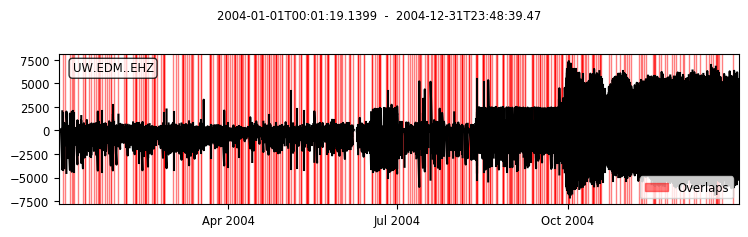

6880 Trace(s) in Stream:

UW.EDM..EHZ | 2004-01-01T00:01:19.139900Z - 2004-01-01T01:04:58.139900Z | 6.7 Hz, 25461 samples
...
(6878 other traces)
...
UW.EDM..EHZ | 2004-12-31T20:49:53.570000Z - 2004-12-31T23:48:39.470000Z | 6.7 Hz, 71507 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [74]:
# calculate frequencie bands AND save stream
jdays = ['{:03d}'.format(jday) for jday in range(1,367)]
print(jdays)
st_long = obspy.Stream()
for i, jday in enumerate(jdays,1):
    st_dec = freq_bands(jday)
    st_long += st_dec
    
    sys.stdout.write('\r{} of {}\n'.format(i, len(jdays)))
    sys.stdout.flush()

st_long.write("tmp/st_2004.mseed", format="MSEED") # save stream
st_long.detrend('demean')
st_long.plot()
st_long

In [649]:
file_list = sorted(glob.glob('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/*/EDM.UW.2004.*'))

xdays = [file.split('/')[7] for file in file_list] # for these days a seismic record exists
days = ['{:03d}'.format(day) for day in range(159,162)] # I'm interessted in these days
    
jdays = list(set(xdays).intersection(days)) # days in both lists
len(jdays)

2

In [642]:
# to save a masked stream

st_copy = st_long.copy() # copy original stream

for tr in st_copy: # demask stream
    if isinstance(tr.data, np.ma.masked_array):
        tr.data = tr.data.filled(np.nan)

#st_copy.write("tmp/st_2004.mseed", format="MSEED") # save stream copy (demasked)

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


## Read

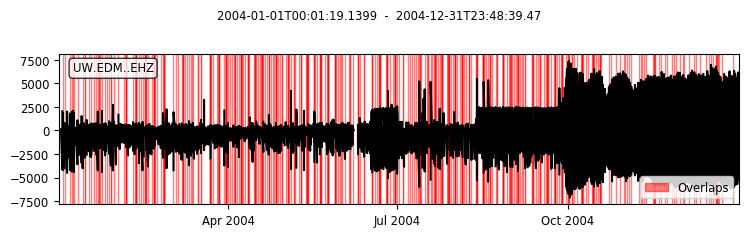

6163 Trace(s) in Stream:

UW.EDM..EHZ | 2004-01-01T00:01:19.139900Z - 2004-01-01T01:04:58.139900Z | 6.7 Hz, 25461 samples
...
(6161 other traces)
...
UW.EDM..EHZ | 2004-12-31T20:49:53.570000Z - 2004-12-31T23:48:39.470000Z | 6.7 Hz, 71507 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [2]:
st_r = obspy.read('tmp/st_2004.mseed')
st_r.detrend('demean')
#st_r.merge()
st_r.plot()
st_r

In [3]:
all_files = sorted(glob.glob('tmp/_tmp_fl_*.csv'))
li = []
for filename in all_files:
    frame = pd.read_csv(filename)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df

,rsam,mf,hf,dsar
time,,,,
2004-01-01 00:00:00,4.225687e+09,2.622182e+09,3.185225e+09,1.822622
2004-01-01 00:10:00,3.837808e+09,2.616428e+09,3.402291e+09,1.724384
2004-01-01 00:20:00,3.625956e+09,2.617689e+09,3.243184e+09,1.704505
2004-01-01 00:30:00,3.689931e+09,2.411944e+09,3.773808e+09,1.505721
2004-01-01 00:40:00,3.676099e+09,2.508885e+09,3.718501e+09,1.437332
...,...,...,...,...
2004-12-31 22:50:00,3.218271e+11,1.683789e+11,6.487640e+10,4.347158
2004-12-31 23:00:00,3.257338e+11,1.700460e+11,6.750585e+10,4.176247
2004-12-31 23:10:00,3.096150e+11,1.705651e+11,6.409872e+10,4.438176


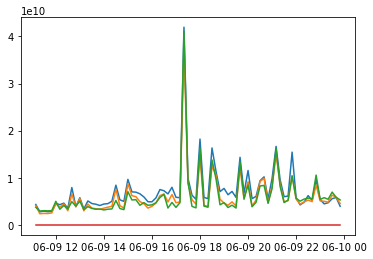

In [71]:
plt.plot(df) # detrend and filled with 0

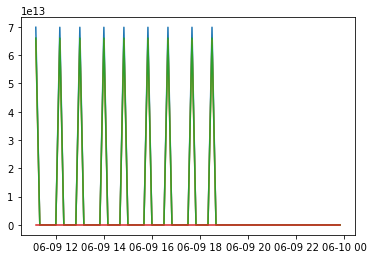

In [679]:
plt.plot(df)# not detrended and filled with 999999

In [82]:
st_long.merge()

UW.EDM..EHZ | 2004-01-01T00:01:19.139900Z - 2004-12-31T23:48:39.539900Z | 6.7 Hz, 210810937 samples (masked)

In [84]:
st_long[0].stats

         network: UW
         station: EDM
        location: 
         channel: EHZ
       starttime: 2004-01-01T00:01:19.139900Z
         endtime: 2004-12-31T23:48:39.539900Z
   sampling_rate: 6.666666666666667
           delta: 0.15
            npts: 210810937
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 102, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 4096, 'filesize': 9371648})
      processing: ["ObsPy 1.2.2: detrend(options={}::type='demean')", "ObsPy 1.2.2: filter(options={'freq': 3.3333333333333335, 'maxorder': 12}::type='lowpass_cheby_2')", 'ObsPy 1.2.2: decimate(factor=15::no_filter=False::strict_length=False)', "ObsPy 1.2.2: detrend(options={}::type='demean')"]

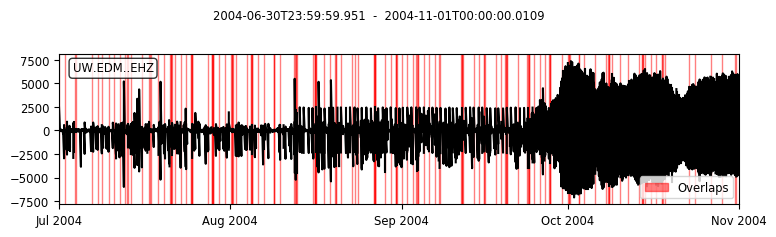

1 Trace(s) in Stream:
UW.EDM..EHZ | 2004-06-30T23:59:59.951000Z - 2004-10-31T23:59:59.951000Z | 6.7 Hz, 70848001 samples (masked)

In [63]:
# trim stream
start_trim = obspy.UTCDateTime(2004,7,1)
end_trim = obspy.UTCDateTime(2004,11,1)
st_trim = st_r.copy()
st_trim.trim(start_trim, end_trim)
st_trim.plot()
st_trim.merge()
st_trim

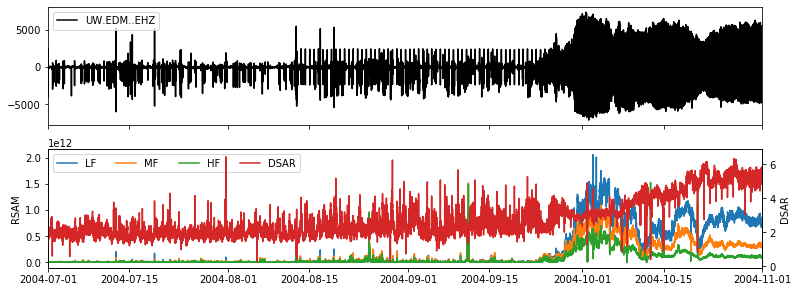

In [65]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(st_trim[0].times('matplotlib'), st_trim[0].data, color='k', 
           label='{}.{}..{}'.format(st_trim[0].stats['network'],
                                    st_trim[0].stats['station'],
                                    st_trim[0].stats['channel']))
ax[1].plot(df['rsam'], label='LF')
ax[1].plot(df['mf'], label='MF')
ax[1].plot(df['hf'], label='HF')
ax[1].plot(np.nan, label='DSAR')

ax2 = ax[1].twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax[1].set_xlim(start_trim.datetime, end_trim.datetime)

ax[1].set_ylabel('RSAM')
ax2.set_ylabel('DSAR')
ax[0].legend(loc='upper left')
ax[1].legend(ncol=4, loc='upper left')

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


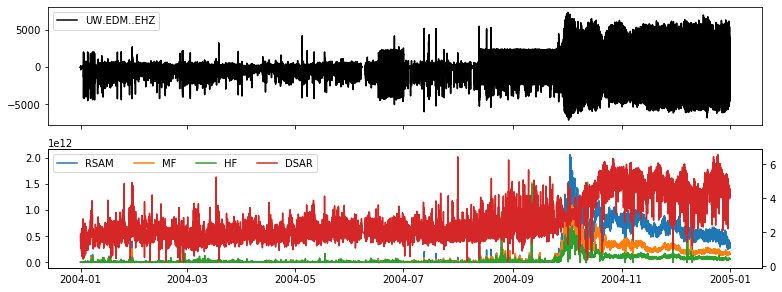

In [89]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
           label='{}.{}..{}'.format(st[0].stats['network'],st[0].stats['station'],st[0].stats['channel']))
#ax[0].set_ylim(-4000,4000)
ax[1].plot(df['rsam'], label='RSAM')
ax[1].plot(df['mf'], label='MF')
ax[1].plot(df['hf'], label='HF')
ax[1].plot(np.nan, label='DSAR')

ax2 = ax[1].twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)

ax[0].legend(loc='upper left')
ax[1].legend(ncol=4, loc='upper left')

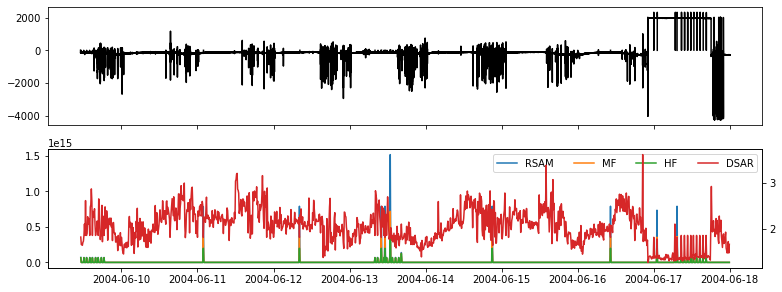

In [424]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k')
#ax[0].set_ylim(-4000,4000)
ax[1].plot(df['rsam'], label='RSAM')
ax[1].plot(df['mf'], label='MF')
ax[1].plot(df['hf'], label='HF')
ax[1].plot(np.nan, label='DSAR')

ax2 = ax[1].twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax[1].legend(ncol=4)

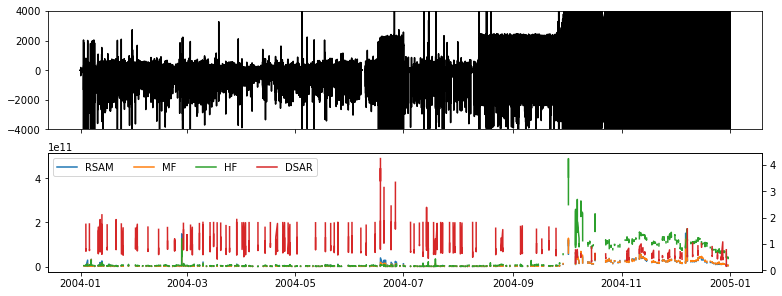

In [133]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k')
ax[0].set_ylim(-4000,4000)
ax[1].plot(df['rsam'], label='RSAM')
ax[1].plot(df['mf'], label='MF')
ax[1].plot(df['hf'], label='HF')
ax[1].plot(np.nan, label='DSAR')

ax2 = ax[1].twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax[1].legend(ncol=4)

In [141]:
import datetime
datetime.datetime(2004,5,1)

datetime.datetime(2004, 5, 1, 0, 0)

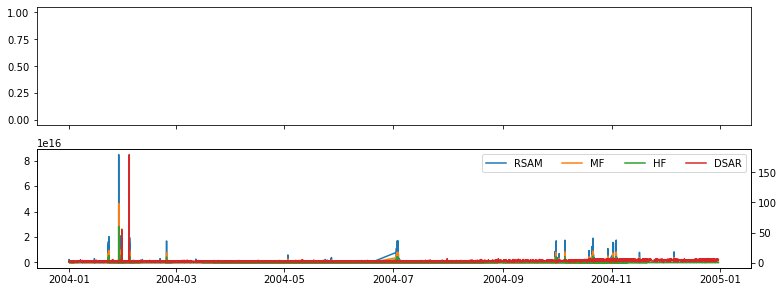

In [8]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(np.nan,np.nan, color='k')
ax[1].plot(df['rsam'], label='RSAM')
ax[1].plot(df['mf'], label='MF')
ax[1].plot(df['hf'], label='HF')
ax[1].plot(np.nan, label='DSAR')

ax2 = ax[1].twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax[1].legend(ncol=4)

In [425]:
import multiprocessing
from functools import partial

In [ ]:
st_long = obspy.Stream()
days = ['{:03d}'.format(jday) for jday in range(161,170)]
print(days)
for i, day in enumerate(days,1):
    try:
        st_dec = freq_bands(day)
        #st_dec.plot()
        st_long += st_dec
    except:
        pass
    
    sys.stdout.write('\r{} of {}'.format(i, len(days)))
    sys.stdout.flush()
   
st_long.merge()
st_long

In [92]:
jdays = ['{:03d}'.format(jday) for jday in range(1,17)]

p = multiprocessing.Pool(processes=16)
st_long = obspy.Stream()
for i, st in enumerate(p.imap(partial(freq_bands),jdays)):
    
    st_long += st # st is downsampled
    
    sys.stdout.write('\r{} of {}'.format(i, len(jdays)))
    sys.stdout.flush()
p.close()
p.join()
st_long.merge()

2004-01-15T00:00:00.000000Z
2004-01-15T00:00:00.000000Z DONE


Process ForkPoolWorker-949:
Process ForkPoolWorker-951:
Process ForkPoolWorker-963:


KeyboardInterrupt: 

Process ForkPoolWorker-956:
Process ForkPoolWorker-959:
Process ForkPoolWorker-960:
Process ForkPoolWorker-958:
Process ForkPoolWorker-962:
Process ForkPoolWorker-954:
Process ForkPoolWorker-955:
Process ForkPoolWorker-965:
Process ForkPoolWorker-964:
Process ForkPoolWorker-961:
Process ForkPoolWorker-953:
Process ForkPoolWorker-952:
Process ForkPoolWorker-957:
Traceback (most recent call last):
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multipro

KeyboardInterrupt
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/multiprocessing/pool.py", line 114, 

In [ ]:
jdays = range(1,367)

p = multiprocessing.Pool(processes=10)

p.map(freq_bands, jdays)